<a href="https://colab.research.google.com/github/EricCallaway/Music_Recommendation_Application/blob/main/music_recommender_system_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [276]:
import pandas as pd
import numpy as np
import re
import string
import nltk
import matplotlib.pyplot as plt

from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from keras import Sequential
from keras.layers import Embedding, Dropout, LSTM, Dense, Reshape
from keras.optimizers import Adam

In [90]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [91]:
df = pd.read_csv('/content/drive/MyDrive/Data/Recommender_System/trainIdx1.csv')
track_data = pd.read_csv('/content/drive/MyDrive/Data/Recommender_System/trackData1.csv')

In [ ]:
track_data.head()

In [94]:
track_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 507172 entries, 0 to 507171
Data columns (total 24 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   TrackID     507172 non-null  int64  
 1   AlbumID     507172 non-null  object 
 2   ArtistID    507172 non-null  object 
 3   GenreID     475968 non-null  float64
 4   GenreID2    283851 non-null  float64
 5   GenreID3    165351 non-null  float64
 6   GenreID4    86291 non-null   float64
 7   GenreID5    43846 non-null   float64
 8   GenreID6    24444 non-null   float64
 9   GenreID7    16675 non-null   float64
 10  GenreID8    10925 non-null   float64
 11  GenreID9    7667 non-null    float64
 12  GenreID10   5573 non-null    float64
 13  GenreID11   4806 non-null    float64
 14  GenreID12   3254 non-null    float64
 15  GenreID13   2608 non-null    float64
 16  GenreID14   1994 non-null    float64
 17  GenreID15   1456 non-null    float64
 18  GenreID16   436 non-null     float64
 19  Ge

In [97]:
track_data = track_data.drop(track_data.columns[4:], axis=1)
track_data = track_data.dropna(subset=["GenreID"])

In [99]:
track_data.head()

,TrackID,AlbumID,ArtistID,GenreID
0,0,224058,587636,349388.0
2,2,10930,454149,349388.0
3,3,403310,78755,211566.0
4,4,359171,614925,147073.0
5,5,187049,196558,247563.0


In [98]:
track_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 475968 entries, 0 to 507171
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   TrackID   475968 non-null  int64  
 1   AlbumID   475968 non-null  object 
 2   ArtistID  475968 non-null  object 
 3   GenreID   475968 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 18.2+ MB


In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999999 entries, 0 to 999998
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   0       999999 non-null  int64
 1   507696  999999 non-null  int64
 2   90      999999 non-null  int64
dtypes: int64(3)
memory usage: 22.9 MB


In [101]:
df = df.rename(columns={"0": "UserID", "507696": "ItemID", "90": "Score"})

In [213]:
merged_df = pd.merge(df, track_data, left_on='ItemID', right_on='TrackID', how='left')

In [214]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 999999 entries, 0 to 999998
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   UserID    999999 non-null  int64  
 1   ItemID    999999 non-null  int64  
 2   Score     999999 non-null  int64  
 3   TrackID   451472 non-null  float64
 4   AlbumID   451472 non-null  object 
 5   ArtistID  451472 non-null  object 
 6   GenreID   451472 non-null  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 61.0+ MB


In [215]:
merged_df = merged_df.dropna(subset=["GenreID"])

In [216]:
merged_df.head()

,UserID,ItemID,Score,TrackID,AlbumID,ArtistID,GenreID
26,0,127640,50,127640.0,113323,592747,85012.0
30,0,193714,30,193714.0,26137,180037,531386.0
32,0,522229,0,522229.0,94522,452599,600770.0
34,0,112040,90,112040.0,450906,392726,600770.0
37,0,464229,90,464229.0,453488,9101,600770.0


In [217]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 451472 entries, 26 to 999998
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   UserID    451472 non-null  int64  
 1   ItemID    451472 non-null  int64  
 2   Score     451472 non-null  int64  
 3   TrackID   451472 non-null  float64
 4   AlbumID   451472 non-null  object 
 5   ArtistID  451472 non-null  object 
 6   GenreID   451472 non-null  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 27.6+ MB


In [226]:
merged_df['AlbumID'] = merged_df['AlbumID'].replace('None', 0)
merged_df['ArtistID'] = merged_df['ArtistID'].replace('None', 0)


In [ ]:
# importing pandas as pd
import pandas as pd
 
# sample dataframe
df = pd.DataFrame({
    'A': [1, 2, 3, 4, 5],
    'B': ['a', 'b', 'c', 'd', 'e'],
    'C': [1.1, '1.0', '1.3', 2, 5]})
 
# using dictionary to convert specific columns
convert_dict = {'A': int,
                'C': float
                }
 
df = df.astype(convert_dict)
print(df.dtypes)

In [228]:
convert_dict = {
    'UserID' : float,
    'ItemID' : float,
    'Score' : float,
    'AlbumID' : float,
    'ArtistID' : float
}

merged_df = merged_df.astype(convert_dict)
print(merged_df.dtypes)


UserID      float64
ItemID      float64
Score       float64
TrackID     float64
AlbumID     float64
ArtistID    float64
GenreID     float64
dtype: object


In [229]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 451472 entries, 26 to 999998
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   UserID    451472 non-null  float64
 1   ItemID    451472 non-null  float64
 2   Score     451472 non-null  float64
 3   TrackID   451472 non-null  float64
 4   AlbumID   451472 non-null  float64
 5   ArtistID  451472 non-null  float64
 6   GenreID   451472 non-null  float64
dtypes: float64(7)
memory usage: 27.6 MB


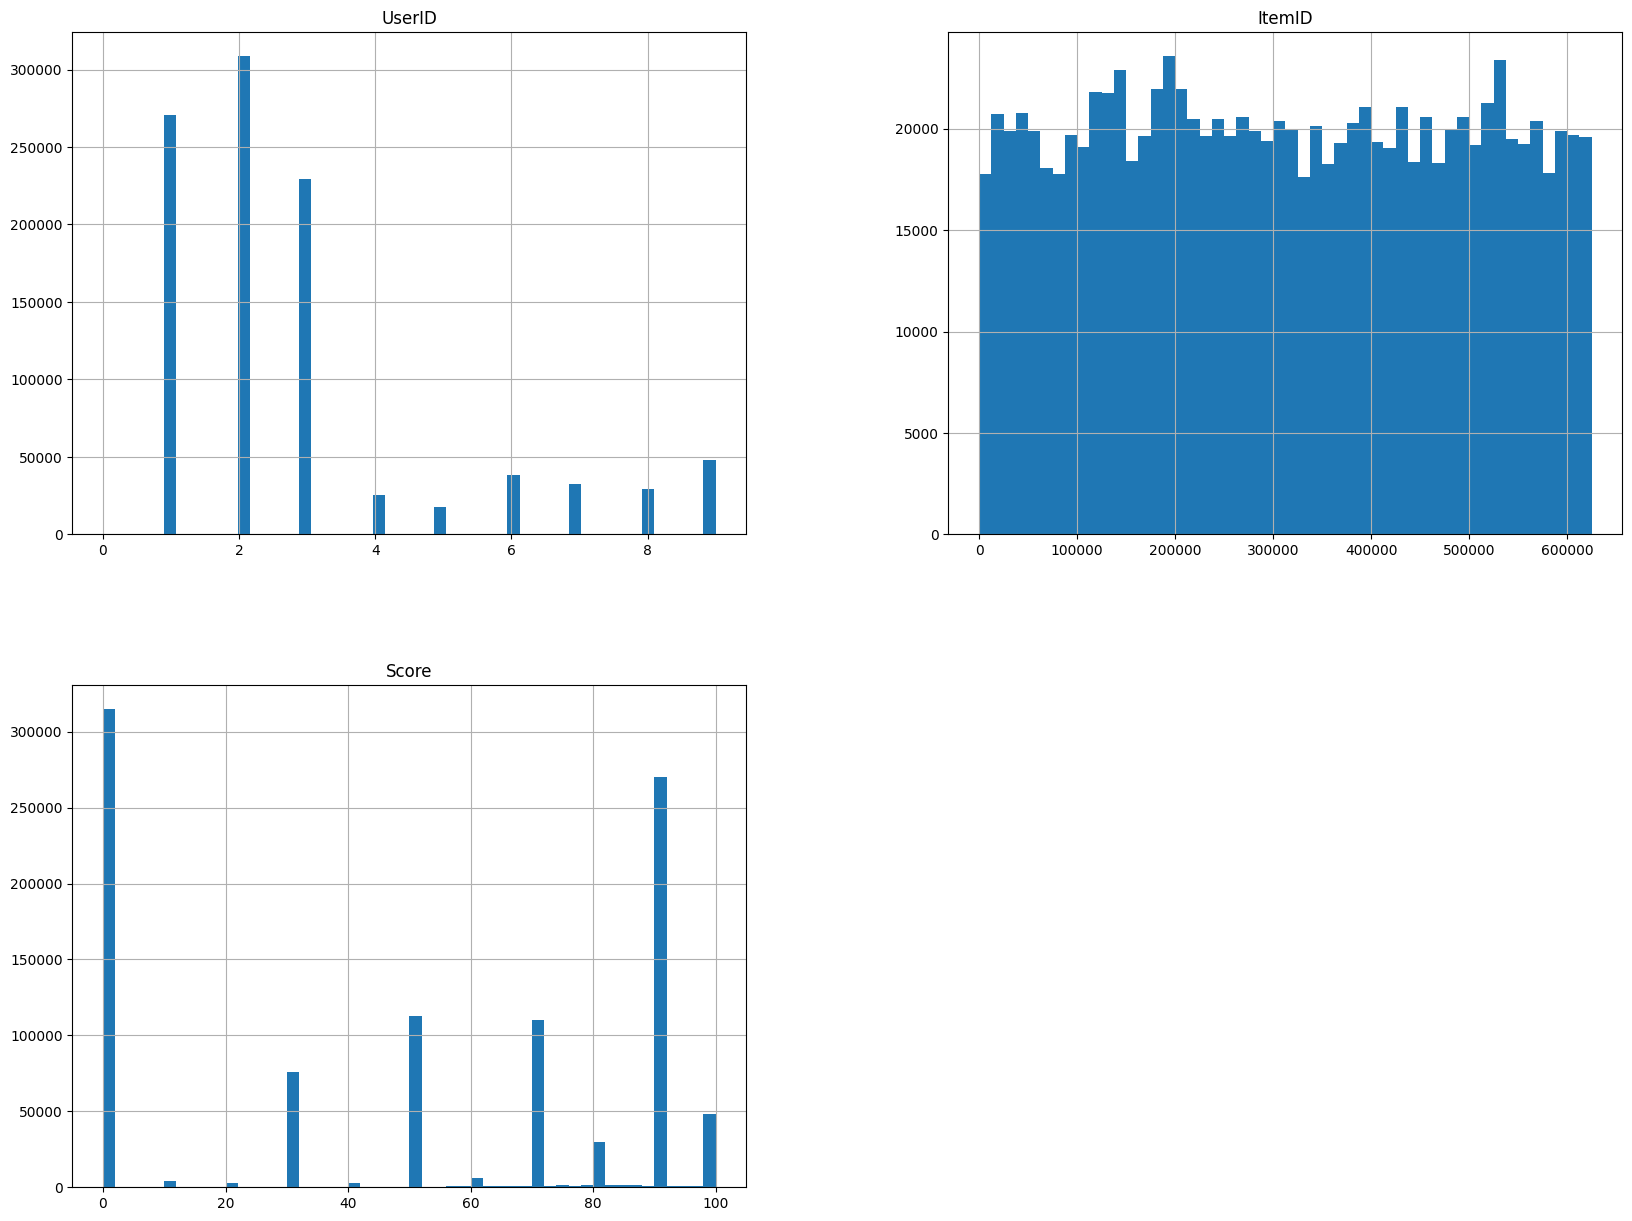

In [63]:
df.hist(bins=50, figsize=(20,15))
plt.show()

In [254]:
X = merged_df[['UserID', 'ItemID', 'TrackID', 'GenreID', 'ArtistID', 'AlbumID']]
y = merged_df['Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1337)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train, random_state=1337)

In [255]:
print(f"Train Set dimensions: X Train: {X_train.shape}, Y Train: {y_train.shape}")
print(f"Validation Set dimensions: X Validation: {X_val.shape}, Y Validation: {y_val.shape}")
print(f"Test Set dimensions: X Test {X_test.shape}, Y Test: {y_test.shape}")

Train Set dimensions: X Train: (270882, 6), Y Train: (270882,)
Validation Set dimensions: X Validation: (90295, 6), Y Validation: (90295,)
Test Set dimensions: X Test (90295, 6), Y Test: (90295,)


In [256]:
# # Load the data into Numpy arrays
X_train = np.array(X_train.iloc[:, [0, 1, 2, 3, 4, 5]])
X_val = np.array(X_val.iloc[:, [0,1,2,3,4,5]])
y_train = np.array(y_train)
y_val = np.array(y_val)

In [257]:
# Reshape the input data for the LSTM model
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

In [251]:
X_val.shape

(90295, 1, 6)

In [258]:
# Reshape the input data to a 3D tensor
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[2]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[2]))

In [288]:
# Define the model architecture
model = Sequential()
model.add(LSTM(3, activation='relu', input_shape=(1, 6), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(3, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(1, activation='relu'))

In [290]:
# Compile the model
model.compile(loss='mean_squared_logarithmic_error', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

In [291]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=10)

Epoch 1/10
8466/8466 [==============================] - 42s 5ms/step - loss: 12.8750 - accuracy: 0.2818 - val_loss: 12.8757 - val_accuracy: 0.2819
Epoch 2/10
8466/8466 [==============================] - 39s 5ms/step - loss: 12.8750 - accuracy: 0.2818 - val_loss: 12.8757 - val_accuracy: 0.2819
Epoch 3/10
8466/8466 [==============================] - 44s 5ms/step - loss: 12.8750 - accuracy: 0.2818 - val_loss: 12.8757 - val_accuracy: 0.2819
Epoch 4/10
8466/8466 [==============================] - 43s 5ms/step - loss: 12.8750 - accuracy: 0.2818 - val_loss: 12.8757 - val_accuracy: 0.2819
Epoch 5/10
8466/8466 [==============================] - 36s 4ms/step - loss: 12.8749 - accuracy: 0.2818 - val_loss: 12.8757 - val_accuracy: 0.2819
Epoch 6/10
8466/8466 [==============================] - 37s 4ms/step - loss: 12.8750 - accuracy: 0.2818 - val_loss: 12.8757 - val_accuracy: 0.2819
Epoch 7/10
8466/8466 [==============================] - 37s 4ms/step - loss: 12.8750 - accuracy: 0.2818 - val_loss: 12

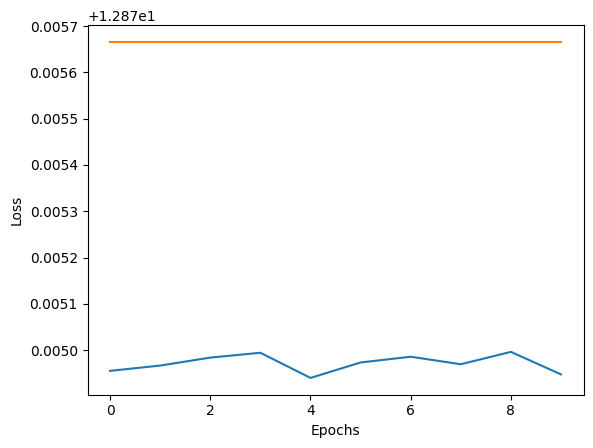

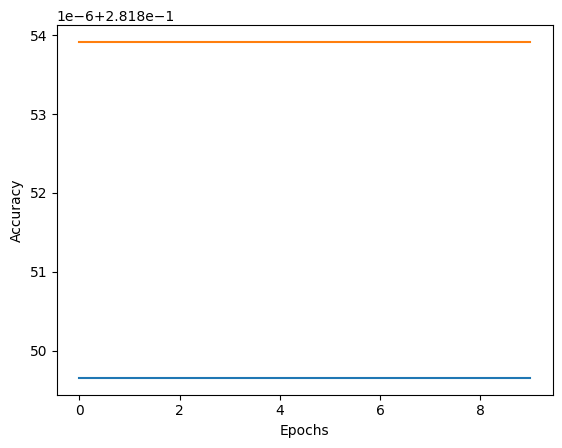

In [292]:
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()